# IMPORT PACKAGES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/MSc_project/.MAIN

Mounted at /content/drive
/content/drive/My Drive/MSc_project/.MAIN


In [2]:
import pandas as pd 
import pickle
import json
import os
import os.path
import numpy as np
import seaborn as sns
from collections import defaultdict
import joblib
import matplotlib.pyplot as plt
from matplotlib.ticker import (
                               FormatStrFormatter, 
                               AutoMinorLocator,
                               FuncFormatter,
                               )
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%matplotlib inline
from scipy.spatial import distance
import math

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import os
# os.chdir('G:\My Drive\MSc_project\.MAIN')


# TWEET SCORES

In [ ]:
hashtags = ['avengers','borisjohnson','blm','brexit','climatechange','covid','gaza','loveisland','monkeypox','nhs','olivianewtonjohn','supercup','UkraineWar']

for h_i,hashtag in enumerate(hashtags):

    df = pd.read_csv(f'multisource_analysis/data/{hashtag}_scored_tweets.csv')
    df.drop(['Unnamed: 0','hashtag','user_id','target'], inplace = True, axis =1)

    if h_i == 0:
        all_df = df.copy()
    else:   
        all_df = pd.concat( [all_df, df ], axis = 0 )

In [ ]:
infectors = all_df.copy()[all_df['is-target']==1]
informers = all_df.copy()[all_df['is-informer']==1]

infectors.insert(0, 'label', value = [1]*len(infectors))
informers.insert(0, 'label', value = [0]*len(informers))


infectors.drop(['is-target','is-infector','is-informer','text'], axis =1, inplace = True)
informers.drop(['is-target','is-infector','is-informer','text'], axis =1, inplace = True)


data = pd.concat([infectors,informers],axis=0)

labels = data['label'].tolist()

data.drop(['label','num_male','num_female','gender'], axis=1,inplace=True)

data['sentiment'].replace('neutral', 0, inplace = True)
data['sentiment'].replace('negative', 1, inplace = True)
data['sentiment'].replace('positive', 2, inplace = True)

In [ ]:
data.columns

Index(['polarity', 'subjectivity', 'text_len', 'text_word_count', 'politeness',
       'offensive', 'sentiment', 'neg', 'neu', 'pos', 'compound',
       'grammar-word-score', 'grammar-sentence-score', 'Kincaid', 'ARI',
       'Coleman-Liau', 'FleschReadingEase', 'GunningFogIndex', 'LIX',
       'SMOGIndex', 'RIX', 'DaleChallIndex', 'complex_words',
       'complex_words_dc', 'topic', 'arts_&_culture',
       'business_&_entrepreneurs', 'celebrity_&_pop_culture',
       'diaries_&_daily_life', 'family', 'fashion_&_style', 'film_tv_&_video',
       'fitness_&_health', 'food_&_dining', 'gaming', 'learning_&_educational',
       'music', 'news_&_social_concern', 'other_hobbies', 'relationships',
       'science_&_technology', 'sports', 'travel_&_adventure',
       'youth_&_student_life', 'topic_single', 'pop_culture', 'daily_life',
       'sports_&_gaming', 'irony', 'emoji', 'joy', 'sadness', 'others',
       'anger', 'surprise', 'disgust', 'hateful', 'targeted', 'aggressive',
       'fear

## METHOD 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=55)

# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# {'learning_rate': 0.3, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight': 1, 'max_delta_step': 0, 'subsample': 0.8}

model = XGBClassifier(use_label_encoder=False, learning_rate=0.3, n_estimators =  100, objective = 'binary:logistic', max_depth = 6, min_child_weight = 1, max_delta_step = 0, subsample = 0.8)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.8792297512232434


In [ ]:
from xgboost import cv
import xgboost as xgb

# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=data,label=labels)

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [ ]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.595966,0.008789,0.595202,0.006884
1,0.638702,0.006728,0.637111,0.011069
2,0.661556,0.003883,0.659233,0.005665
3,0.674100,0.005026,0.670564,0.005411
4,0.682205,0.004393,0.678957,0.004695


## FEATURE IMPORTANCE

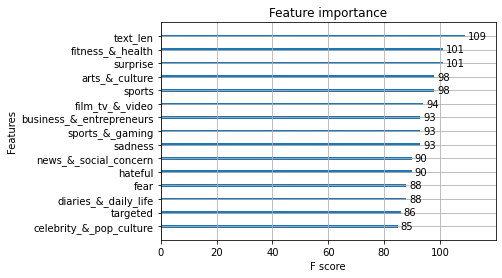

<Figure size 1080x1440 with 0 Axes>

In [ ]:
import xgboost as xgb
xgb.plot_importance(model, max_num_features=15)
plt.figure(figsize = (15, 20))
plt.show()

## f1 scores

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
        print('F1 score = {:.3e}'.format(tp/(tp + 0.5*(fp+fn))))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

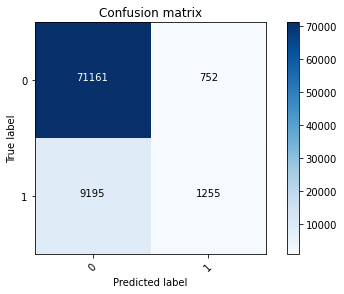

Precision =     0.625
Recall (TPR) =  0.120
Fallout (FPR) = 1.046e-02
F1 score = 2.015e-01


In [ ]:
y_pred = model.predict(X_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

## Method 2

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=2)

# find optimal max_depth

cv_params = {'max_depth': [1,2,3,4,5,6], 'min_child_weight': [1,2,3,4]}    # parameters to be tries in the grid search
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic'}   #other parameters, fixed for the moment 
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)

In [ ]:
csv.fit(X_train, y_train)

In [ ]:
csv.best_params_ # choose the max_depth

In [ ]:
cv_params = {'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight':1}
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5) 
csv.fit(X_train, y_train)

In [ ]:
csv.best_params_ # obtain the max-delta step and optimal subsample

In [ ]:
# search for optimal learning rate

cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}
fix_params['max_delta_step'] = 0
fix_params['subsample'] = 0.8

In [ ]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5) 
csv.fit(X_train, y_train)

In [ ]:
csv.best_params_

In [ ]:
fix_params['learning_rate'] = 0.3
params_final =  fix_params
print(params_final)

In [ ]:
xgdmat_train = xgb.DMatrix(X_train, y_train)
xgdmat_test = xgb.DMatrix(X_test, y_test)
xgb_final = xgb.train(params_final, xgdmat_train, num_boost_round = 100)

In [ ]:
y_pred = xgb_final.predict(xgdmat_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

In [ ]:
y_pred = xgb_final.predict(xgdmat_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

# USER SCORES

In [ ]:
hashtags = ['avengers','blm','brexit','climatechange','covid','gaza','loveisland','monkeypox','nhs','olivianewtonjohn','supercup','UkraineWar']

for h_i,hashtag in enumerate(hashtags):

    df = pd.read_csv(f'multisource_analysis/user_ft_data/{hashtag}_scored_tweets2.csv')
    df.drop(['Unnamed: 0','hashtag','user_id','target'], inplace = True, axis =1)

    if h_i == 0:
        all_df = df.copy()
    else:   
        all_df = pd.concat( [all_df, df ], axis = 0 )

In [ ]:
cols = all_df.columns.tolist()
cols = [ x for x in cols if 'user' in x] 
cols = cols + ['num_male','num_female']
cols = [x for x in cols if 'count' not in x]

### RUN

In [ ]:
infectors = all_df[all_df['is-infector']==1]
informers = all_df[all_df['is-informer']==1]

df = pd.concat([infectors,informers], axis = 0 )

In [ ]:
data = df.copy()[cols]
labels = df.copy()['is-infector']

data['user_sentiment_mode'].replace('neutral', 0, inplace = True)
data['user_sentiment_mode'].replace('negative', 1, inplace = True)
data['user_sentiment_mode'].replace('positive', 2, inplace = True)

## METHOD 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state= 52)

# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# {'learning_rate': 0.3, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight': 1, 'max_delta_step': 0, 'subsample': 0.8}

model = XGBClassifier(use_label_encoder=False, learning_rate=0.3, n_estimators =  100, objective = 'binary:logistic', max_depth = 6, min_child_weight = 1, max_delta_step = 0, subsample = 0.8)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.8788445795813355


In [ ]:
from xgboost import cv
import xgboost as xgb

# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=data,label=labels)

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [ ]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.683028,0.005300,0.681320,0.004107
1,0.718467,0.002647,0.716795,0.006154
2,0.733284,0.004421,0.732312,0.008578
3,0.746326,0.007294,0.744355,0.011121
4,0.759710,0.004443,0.756271,0.001819


## FEATURE IMPORTANCE

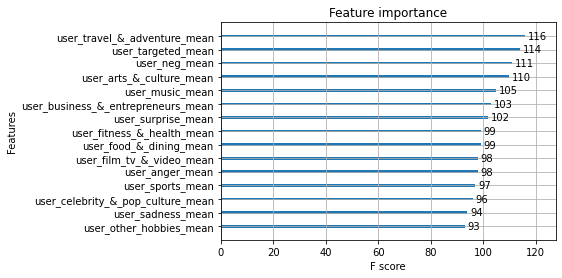

<Figure size 1080x1440 with 0 Axes>

In [ ]:
import xgboost as xgb
xgb.plot_importance(model, max_num_features=15)
plt.figure(figsize = (15, 20))
plt.show()

## f1 scores

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
        print('F1 score = {:.3e}'.format(tp/(tp + 0.5*(fp+fn))))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

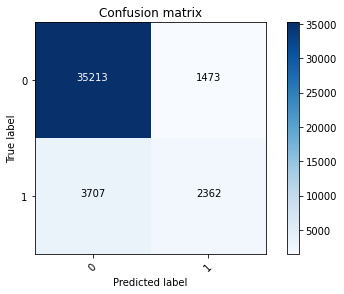

Precision =     0.616
Recall (TPR) =  0.389
Fallout (FPR) = 4.015e-02
F1 score = 4.770e-01


In [ ]:
y_pred = model.predict(X_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

## Method 2

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=2)

# find optimal max_depth

cv_params = {'max_depth': [1,2,3,4,5,6], 'min_child_weight': [1,2,3,4]}    # parameters to be tries in the grid search
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic'}   #other parameters, fixed for the moment 
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)

In [ ]:
csv.fit(X_train, y_train)

In [ ]:
csv.best_params_ # choose the max_depth

In [ ]:
cv_params = {'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight':1}
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5) 
csv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=XGBClassifier(learning_rate=0.2, max_depth=6),
             param_grid={'max_delta_step': [0, 1, 2, 4],
                         'subsample': [0.8, 0.9, 1]},
             scoring='f1')

In [ ]:
csv.best_params_ # obtain the max-delta step and optimal subsample

{'max_delta_step': 0, 'subsample': 0.8}

In [ ]:
# search for optimal learning rate

cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}
fix_params['max_delta_step'] = 0
fix_params['subsample'] = 0.8

In [ ]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5) 
csv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(learning_rate=0.2, max_depth=6,
                                     subsample=0.8),
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]},
             scoring='f1')

In [ ]:
csv.best_params_

{'learning_rate': 0.3}

In [ ]:
fix_params['learning_rate'] = 0.3
params_final =  fix_params
print(params_final)

{'learning_rate': 0.3, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight': 1, 'max_delta_step': 0, 'subsample': 0.8}


In [ ]:
xgdmat_train = xgb.DMatrix(X_train, y_train)
xgdmat_test = xgb.DMatrix(X_test, y_test)
xgb_final = xgb.train(params_final, xgdmat_train, num_boost_round = 100)

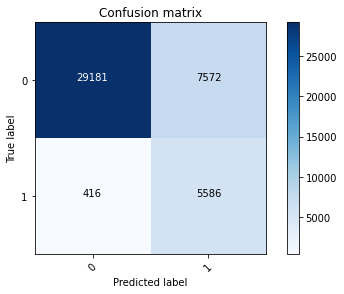

Precision =     0.425
Recall (TPR) =  0.931
Fallout (FPR) = 2.060e-01


In [ ]:
y_pred = xgb_final.predict(xgdmat_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

# USER SCORES + TWEET SCORES



In [ ]:
hashtags = ['avengers','blm','brexit','climatechange','covid','gaza','loveisland','monkeypox','nhs','olivianewtonjohn','supercup','UkraineWar']

for h_i,hashtag in enumerate(hashtags):

    df = pd.read_csv(f'multisource_analysis/user_ft_data/{hashtag}_scored_tweets2.csv')
    df.drop(['Unnamed: 0','hashtag','user_id'], inplace = True, axis =1)
    # df.drop(['Unnamed: 0','hashtag','user_id','target'], inplace = True, axis =1)

    if h_i == 0:
        all_df = df.copy()
    else:   
        all_df = pd.concat( [all_df, df ], axis = 0 )

In [ ]:
fector_df = all_df.copy()[all_df['is-infector']==1]
fector_df.set_index('target',inplace=True)
targ_df = all_df.copy()[all_df['is-target']==1]
targ_df.set_index('target',inplace=True)
t_cols = all_df.columns.tolist()
t_cols = [x for x in t_cols if 'user' not in x]
t_cols = [x for x in t_cols if x not in ['is-target','is-infector','is-informer','num_male','num_female','text','target'] ]

u_cols = all_df.columns.tolist()
u_cols = [ x for x in u_cols if 'user' in x] 
u_cols = u_cols + ['num_male','num_female']
u_cols = [x for x in u_cols if 'count' not in x]

cols = u_cols+t_cols

infector_df = pd.concat( [targ_df[t_cols],fector_df[u_cols] ], axis=1   )


informer_df = all_df[all_df['is-informer']==1][cols]

infector_df['label'] = [1]*len(infector_df)
informer_df['label'] = [0]*len(informer_df)

n1 = int(len(infector_df)*0.7)
n2 = int(len(informer_df)*0.7)

data = pd.concat( [ infector_df.copy().iloc[0:n1], informer_df.copy().iloc[0:n2] ], axis =0)
data = data.sample(frac=1)

data['sentiment'].replace('neutral', 0, inplace = True)
data['sentiment'].replace('negative', 1, inplace = True)
data['sentiment'].replace('positive', 2, inplace = True)
data['user_sentiment_mode'].replace('neutral', 0, inplace = True)
data['user_sentiment_mode'].replace('negative', 1, inplace = True)
data['user_sentiment_mode'].replace('positive', 2, inplace = True)

### TESTING SET

holdout_data = pd.concat( [ infector_df.copy().iloc[n1:],informer_df.copy().iloc[n2:] ], axis =0)
holdout_data = holdout_data.sample(frac=1)

holdout_data['sentiment'].replace('neutral', 0, inplace = True)
holdout_data['sentiment'].replace('negative', 1, inplace = True)
holdout_data['sentiment'].replace('positive', 2, inplace = True)
holdout_data['user_sentiment_mode'].replace('neutral', 0, inplace = True)
holdout_data['user_sentiment_mode'].replace('negative', 1, inplace = True)
holdout_data['user_sentiment_mode'].replace('positive', 2, inplace = True)

## METHOD 1

In [ ]:
X = data[cols]
labels = data['label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=2,shuffle=True)

# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# {'learning_rate': 0.3, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight': 1, 'max_delta_step': 0, 'subsample': 0.8}

model = XGBClassifier(use_label_encoder=False, learning_rate=0.3, n_estimators =  100, objective = 'binary:logistic', max_depth = 6, min_child_weight = 1, max_delta_step = 0, subsample = 0.8)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9771451483560545


In [ ]:
from xgboost import cv
import xgboost as xgb

# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=data,label=labels)

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [ ]:
xgb_cv.head()

## FEATURE IMPORTANCE

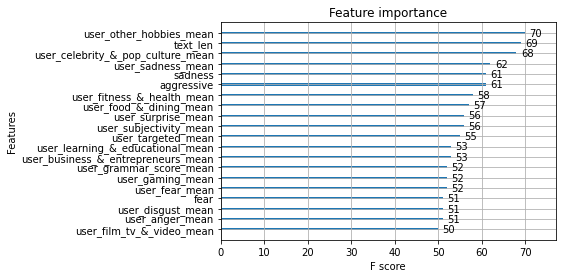

<Figure size 2880x5040 with 0 Axes>

In [ ]:
import xgboost as xgb
xgb.plot_importance(model, max_num_features=20)
plt.figure(figsize = (40, 70))
plt.savefig('diss_figs/historic_tweet_featurs.png', facecolor='w')
plt.show()

## f1 scores

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
        print('F1 score = {:.3e}'.format(tp/(tp + 0.5*(fp+fn))))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

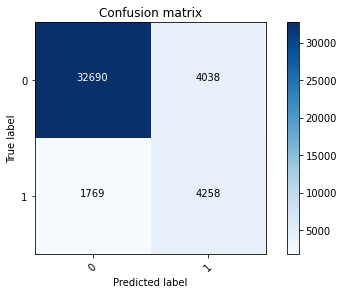

Precision =     0.513
Recall (TPR) =  0.706
Fallout (FPR) = 1.099e-01
F1 score = 5.946e-01


In [ ]:
X_test = holdout_data[cols]
y_test = holdout_data['label']

y_pred = model.predict(X_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

## Method 2

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=2)

# find optimal max_depth

cv_params = {'max_depth': [1,2,3,4,5,6], 'min_child_weight': [1,2,3,4]}    # parameters to be tries in the grid search
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic'}   #other parameters, fixed for the moment 
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)

In [ ]:
csv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=XGBClassifier(learning_rate=0.2),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'min_child_weight': [1, 2, 3, 4]},
             scoring='f1')

In [ ]:
csv.best_params_ # choose the max_depth

{'max_depth': 6, 'min_child_weight': 1}

In [ ]:
cv_params = {'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight':1}
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5) 
csv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=XGBClassifier(learning_rate=0.2, max_depth=6),
             param_grid={'max_delta_step': [0, 1, 2, 4],
                         'subsample': [0.8, 0.9, 1]},
             scoring='f1')

In [ ]:
csv.best_params_ # obtain the max-delta step and optimal subsample

{'max_delta_step': 0, 'subsample': 0.8}

In [ ]:
# search for optimal learning rate

cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}
fix_params['max_delta_step'] = 0
fix_params['subsample'] = 0.8

In [ ]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5) 
csv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(learning_rate=0.2, max_depth=6,
                                     subsample=0.8),
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]},
             scoring='f1')

In [ ]:
csv.best_params_

{'learning_rate': 0.3}

In [ ]:
fix_params['learning_rate'] = 0.3
params_final =  fix_params
print(params_final)

{'learning_rate': 0.3, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight': 1, 'max_delta_step': 0, 'subsample': 0.8}


In [ ]:
xgdmat_train = xgb.DMatrix(X_train, y_train)
xgdmat_test = xgb.DMatrix(X_test, y_test)
xgb_final = xgb.train(params_final, xgdmat_train, num_boost_round = 100)

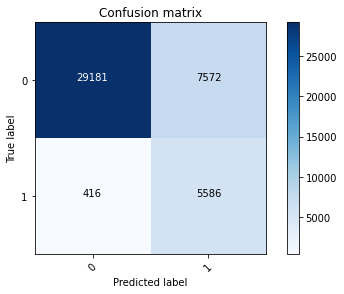

Precision =     0.425
Recall (TPR) =  0.931
Fallout (FPR) = 2.060e-01


In [ ]:
y_pred = xgb_final.predict(xgdmat_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

# 10 FEED USER SCORES + TWEET SCORES 


In [ ]:
hashtags = ['avengers','blm','brexit','climatechange','covid','gaza','loveisland','monkeypox','nhs','olivianewtonjohn','supercup','UkraineWar']

for h_i,hashtag in enumerate(hashtags):

    df = pd.read_csv(f'multisource_analysis/user_ft_data/{hashtag}_scored_tweets_10_feeds.csv')
    df.drop(['Unnamed: 0','hashtag','user_id','target'], inplace = True, axis =1)

    if h_i == 0:
        all_df = df.copy()
    else:   
        all_df = pd.concat( [all_df, df ], axis = 0 )

In [ ]:
fector_df = all_df.copy()[all_df['is-infector']==1]
fector_df.reset_index(inplace=True)
targ_df = all_df.copy()[all_df['is-target']==1]
targ_df.reset_index(inplace=True)
t_cols = all_df.columns.tolist()
t_cols = [x for x in t_cols if 'user' not in x]
t_cols = [x for x in t_cols if x not in ['is-target','is-infector','is-informer','num_male','num_female','text'] ]

u_cols = all_df.columns.tolist()
u_cols = [ x for x in u_cols if 'user' in x] 
u_cols = u_cols + ['num_male','num_female']
u_cols = [x for x in u_cols if 'count' not in x]

cols = u_cols+t_cols

infector_df = pd.concat( [targ_df[t_cols],fector_df[u_cols] ], axis=1   )


informer_df = all_df[all_df['is-informer']==1][cols]

infector_df['label'] = [1]*len(infector_df)
informer_df['label'] = [0]*len(informer_df)


data = pd.concat( [infector_df,informer_df], axis =0)
data = data.sample(frac=1)

In [ ]:
data['sentiment'].replace('neutral', 0, inplace = True)
data['sentiment'].replace('negative', 1, inplace = True)
data['sentiment'].replace('positive', 2, inplace = True)
data['user_sentiment_mode'].replace('neutral', 0, inplace = True)
data['user_sentiment_mode'].replace('negative', 1, inplace = True)
data['user_sentiment_mode'].replace('positive', 2, inplace = True)

## METHOD 1

In [ ]:
X = data[cols]
labels = data['label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=2)

# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# {'learning_rate': 0.3, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight': 1, 'max_delta_step': 0, 'subsample': 0.8}

model = XGBClassifier(use_label_encoder=False, learning_rate=0.3, n_estimators =  100, objective = 'binary:logistic', max_depth = 6, min_child_weight = 1, max_delta_step = 0, subsample = 0.8)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9749970763653374


In [ ]:
from xgboost import cv
import xgboost as xgb

# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=data,label=labels)

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [ ]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.746475,0.003312,0.743279,0.002409
1,0.860126,0.104443,0.855654,0.106835
2,0.947587,0.073679,0.945128,0.077081
3,0.999241,0.000085,0.999231,0.000066
4,0.999348,0.000452,0.999346,0.000455


## FEATURE IMPORTANCE

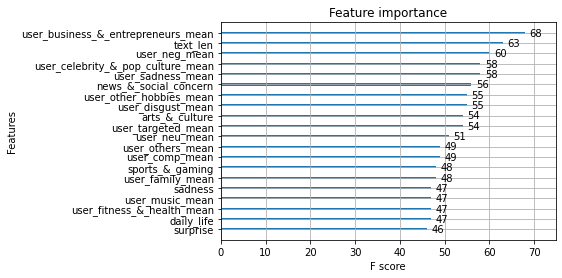

<Figure size 1080x2160 with 0 Axes>

In [ ]:
import xgboost as xgb
xgb.plot_importance(model, max_num_features=20)
plt.figure(figsize = (15, 30))
plt.show()

## f1 scores

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
        print('F1 score = {:.3e}'.format(tp/(tp + 0.5*(fp+fn))))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

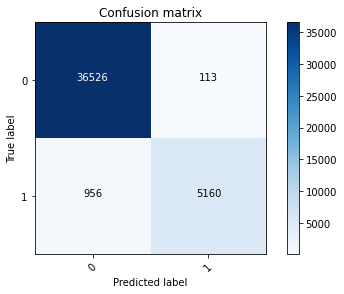

Precision =     0.979
Recall (TPR) =  0.844
Fallout (FPR) = 3.084e-03
F1 score = 9.061e-01


In [ ]:
y_pred = model.predict(X_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);